In [10]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math
%matplotlib inline
from scipy import integrate
from scipy import optimize
from scipy.interpolate import PchipInterpolator

from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from numpy import *
from scipy import signal

from scipy.special import legendre
from scipy.special import eval_legendre
from scipy.special import factorial2

from urllib.request import urlopen


# LOAD SLY TOV SOLUTIONS

url_intermediate_e_c = "https://raw.github.com/esmyrnio/rns_tab_sly/main/sly_out.txt"
#url_high_e_c = "https://raw.github.com/esmyrnio/rns_tab_sly/main/high_ec_data_sly.txt"
#url_low_e_c = "https://raw.github.com/esmyrnio/rns_tab_sly/main/starting_ec_03_rns_solution.txt"

# LOAD SLY EOS

url_eos = "https://raw.github.com/esmyrnio/rns_tab_sly/main/loge_logp_logh_sly.txt"

ur_intermediate = urlopen(url_intermediate_e_c)
#ur_high = urlopen(url_high_e_c) 
#ur_low = urlopen(url_low_e_c) 


ur_eos = urlopen(url_eos)

data_sol = np.loadtxt(ur_intermediate, delimiter=' ', dtype=float)
data_eos = np.loadtxt(ur_eos, delimiter=' ', dtype=float)

# DEFINE CONSTANTS

c=2.9979e10
G=6.67408e-8
Msun=1.989e33
Length = G*Msun/c**2
Time = Length/c
Density = Msun/Length**3
length_squared = 1.346790806509621e+13/pow(100000,2)  # (km^2)
len_squared = 1.346790806509621e+13 # (cm^2)
kscale = 1.112668301525780e-36
kappa = 1.112668301525780e-36*2.9979e10*2.9979e10

# DEFINE FIRST ORDER DERIVATIVE

def di(i,f):
    
    if i == 0:
        return (f[i+1]-f[i])/(ds)
    elif i == N-1:
        return (f[i]-f[i-1])/(ds)
    else:
        return (f[i+1]-f[i-1])/(2*ds)

# DEFINE THEORY COUPLING FUNCTIONS: k(PHI), A(PHI) 

def alpha_phi(phi,veta):
    return veta*phi

def A_of_phi(phi,beta):   
        return np.exp(0.5*beta*phi**2)

# DEFINE SOURCE TERMS FOR METRIC POTENTIALS AND SCALAR

def source_mu(i,s,mu_t,nu_t,phi_t,dnds,dnds2,dmds,dmds2,dfds,dfds2,e_aw,p_aw,r_e):
    
    c = 4*np.pi
    
    p = p_aw
    eps = e_aw
    
    emu = np.exp(2*mu_t[i])
    memu = np.exp(-2*mu_t[i])
    
    r = np.sqrt(r_e)*s[i]/(1-s[i])
    r2 = r_e*pow(s[i]/(1-s[i]),2)
    
    ss = pow(1-s[i],2)/np.sqrt(r_e)
    dn = ss*dnds[i]
    dm = ss*dmds[i]
    dphi = ss*dfds[i]
    
    
    ddphi = pow(1-s[i],4)*dfds2[i]/r_e - dfds[i]*2*pow(1-s[i],3)/r_e
    ddm =   pow(1-s[i],4)*dmds2[i]/r_e - dmds[i]*2*pow(1-s[i],3)/r_e
    
    new = pow(np.exp(0.5*veta*pow(phi_t[i],2)),4)


    if i!=0:
        
        return -r2*(c*new*emu*eps + 0.5*(pow(dm,2)+pow(dphi,2)))
    
    else:
        
        return 0
    




def source_nu(i,s,mu_t,nu_t,phi_t,dnds,dnds2,dmds,dmds2,dfds,dfds2,e_aw,p_aw,r_e):

    c = 8*np.pi*np.exp(2*mu_t[i])
    
    p = p_aw
    eps = e_aw
    
    emu = np.exp(2*mu_t[i])

    
    r = np.sqrt(r_e)*s[i]/(1-s[i])
    r2 = r_e*pow(s[i]/(1-s[i]),2)
    
    ss = pow(1-s[i],2)/np.sqrt(r_e)
    dn = ss*dnds[i]
    dm = ss*dmds[i]
    dphi = ss*dfds[i]
    
    
    ddphi = pow(1-s[i],4)*dfds2[i]/r_e - dfds[i]*2*pow(1-s[i],3)/r_e
    ddm =   pow(1-s[i],4)*dmds2[i]/r_e - dmds[i]*2*pow(1-s[i],3)/r_e
    
    new = pow(np.exp(0.5*veta*pow(phi_t[i],2)),4)

    if i!=0:
        
        return r2*(c*new*p - pow(dn,2) - pow(dphi,2) - ddm - (1/r)*(dm-dn))
       # return r2*c*new*emu*p-r2*pow(dn,2)-r2*pow(dphi,2)- r2*ddm - r*(dm-dn)
    
    else:
        
        return 0

                      
def source_phi(i,s,mu_t,nu_t,phi_t,dnds,dnds2,dmds,dmds2,dfds,dfds2,e_aw,p_aw,r_e):


    c = 4*np.pi
    
    p = p_aw
    eps = e_aw
    
    emu = np.exp(2*mu_t[i])

    
    r = np.sqrt(r_e)*s[i]/(1-s[i])
    r2 = r_e*pow(s[i]/(1-s[i]),2)
    
    ss = pow(1-s[i],2)/np.sqrt(r_e)
    dn = ss*dnds[i]
    dm = ss*dmds[i]
    dphi = ss*dfds[i]
    new = pow(np.exp(0.5*veta*pow(phi_t[i],2)),4)
    
    ddphi = pow(1-s[i],4)*dfds2[i]/r_e - dfds[i]*2*pow(1-s[i],3)/r_e
    ddm =   pow(1-s[i],4)*dmds2[i]/r_e - dmds[i]*2*pow(1-s[i],3)/r_e
    
    alpha = alpha_phi(phi_t[i],veta)
   
    if i!=0:

        return r*(-4*emu*np.pi*r*(alpha*new*(3*p-eps)*(1+r*dm)+r*new*(p-eps)*dphi)\
               +dphi*(-2+r2*ddm))/(1+r*dm) + 2*r*dphi
    else:
        return 0

# CUBIC HERMITE INTERPOLATION OF TABULATED EOS  

log_p = data_eos[:,1]
log_e = data_eos[:,0]
log_h = data_eos[:,2]


def p_at_h(hh):
    
    return pow(10,PchipInterpolator(log_h,log_p)(np.log10(hh)))

def e_at_p(pp):
    
    return pow(10,PchipInterpolator(log_p,log_e)(np.log10(pp)))

def h_at_p(pp):
    
    return pow(10,PchipInterpolator(log_p,log_h)(np.log10(pp)))

def p_at_e(ee):
    
    return pow(10.0,PchipInterpolator(log_e,log_p)(np.log10(ee)));

s = data_sol[:,2] # 1301x1
N = len(s)
ds = s[1]-s[0]
surface_indx = np.argmin((s-1/2)**2)

# CALCULATE GUESS SOLUTION

re_t = 1.65541e-01
re_guess = re_t


p_t = data_sol[:,13]*kscale # KAPPA*G/(C*C*C*C)
eps_t = data_sol[:,12]*kappa 


raw_t = data_sol[:,4]
g_t = data_sol[:,5]

nu_t = (g_t+raw_t)/2
mu_t = (g_t-raw_t)/2
phi_t = nu_t


# COMPUTE CENTER

ec_t = 1.1 # (X 1e15 gr/cm^3)
eps_t[0] = ec_t
p_t[0] = p_at_e(ec_t)

# DEFINE THEORY PARAMETERS

veta = -5.0 # dimensionless

surface_indx = np.argmin((s-1/2)**2)

# DEFINE MONITORING FACTOR (r_e)

relative_error = 1e-7

# DEFINE UNDER-RELAXATION FACTOR

# under_relaxation_factor = 0.2


iterations = 0

mu_new = np.zeros(N)
nu_new = np.zeros(N)
phi_new = np.zeros(N)

dfds_main = np.zeros(N)
dmds_main = np.zeros(N)
dnds_main = np.zeros(N)

dnds2_main = np.zeros(N)
dfds2_main = np.zeros(N)
dmds2_main = np.zeros(N)

sources_n = np.zeros(N)
sources_m = np.zeros(N)
sources_ph = np.zeros(N)

h_aw = np.zeros(N)
p_aw = np.zeros(N)
e_aw = np.zeros(N)

h_center = h_at_p(p_at_e(ec_t))
h_min = h_at_p(p_t[surface_indx])



# ----- MAIN ITERATION CYCLE ------ #

while True:


    # RESCALE

    mu_hat = mu_t/pow(re_t,2)
    nu_hat = nu_t/pow(re_t,2)
    phi_hat = phi_t/pow(re_t,1)



    # SQUARED
    r_e = h_center/(nu_hat[surface_indx]-nu_hat[0]+ 0.5*veta*pow(phi_hat[surface_indx],2)\
                                                                - 0.5*veta*pow(phi_hat[0],2))


    #CALCULATE NEW ENTHALPY

    for i in range(0,N):


        h_aw[i]  = h_min + (r_e*(nu_hat[surface_indx]
                           -nu_hat[i] + 0.5*veta*pow(phi_hat[surface_indx],2)\
                            - 0.5*veta*pow(phi_hat[i],2)))


    # CALCULATE NEW PRESSURE AND EN_DENSITY

    p_aw[:surface_indx+1] = p_at_h(h_aw[:surface_indx+1])
    e_aw[:surface_indx+1] = e_at_p(p_aw[:surface_indx+1])

    p_aw[surface_indx+1:] = 0
    e_aw[surface_indx+1:] = 0


    # CALCULATE DERIVATIVES

    for i in range(0,N):

        dfds_main[i] = di(i,phi_hat*np.sqrt(r_e))
        dmds_main[i] = di(i,mu_hat*r_e)
        dnds_main[i] = di(i,nu_hat*r_e)

    # SMOOTH OUT 1ST ORDER DERIVATIVE SOLUTIONS USING A SAVITZKY-GOLAY FILTER

    dfds_real = dfds_main
    dmds_real = dmds_main
    dnds_real = dnds_main


    for i in range(0,N):

        dfds2_main[i] = di(i,dfds_real)
        dmds2_main[i] = di(i,dmds_real)
        dnds2_main[i] = di(i,dnds_real)

    # SMOOTH OUT 2ND ORDER DERIVATIVE SOLUTIONS USING A SAVITZKY-GOLAY FILTER

    dfds2_real = dfds2_main
    dmds2_real = dmds2_main
    dnds2_real = dnds2_main

    
    # COMPUTE SOURCE TERMS
    
    for i in range(0,N):


        sources_n[i] = source_nu(i,s,mu_hat*r_e,nu_hat*r_e,phi_hat*np.sqrt(r_e),dnds_real,dnds2_real,dmds_real,dmds2_real,dfds_real,dfds2_real,e_aw[i],p_aw[i],r_e)
        sources_m[i] = source_mu(i,s,mu_hat*r_e,nu_hat*r_e,phi_hat*np.sqrt(r_e),dnds_real,dnds2_real,dmds_real,dmds2_real,dfds_real,dfds2_real,e_aw[i],p_aw[i],r_e)
        sources_ph[i] = source_phi(i,s,mu_hat*r_e,nu_hat*r_e,phi_hat*np.sqrt(r_e),dnds_real,dnds2_real,dmds_real,dmds2_real,dfds_real,dfds2_real,e_aw[i],p_aw[i],r_e)

    for i in range(1,N):


        mu_new[i] = -eval_legendre(0,0)*(((1-s[i])/s[i])*integrate.simps((1/pow(1-s[0:i+1],2))\
                 *sources_m[0:i+1],dx=ds)\
                + integrate.simps((pow(1-s[i:],-1)/s[i:])*sources_m[i:],dx=ds))

        nu_new[i] = -eval_legendre(0,0)*(((1-s[i])/s[i])*integrate.simps((1/pow(1-s[0:i+1],2))\
                 *sources_n[0:i+1],dx=ds)\
                + integrate.simps((pow(1-s[i:],-1)/s[i:])*sources_n[i:],dx=ds))

        phi_new[i] = -eval_legendre(0,0)*(((1-s[i])/s[i])*integrate.simps((1/pow(1-s[0:i+1],2))\
                 *sources_ph[0:i+1],dx=ds)\
                + integrate.simps((pow(1-s[i:],-1)/s[i:])*sources_ph[i:],dx=ds))




    rel_error = abs(1-np.sqrt(np.sqrt(r_e)/re_t))


    mu_new[0] = -integrate.simps(sources_m[1:]/(s[1:]*(1-s[1:])),dx=ds)
    nu_new[0] =   -integrate.simps(sources_n[1:]/(s[1:]*(1-s[1:])),dx=ds)
    phi_new[0] =   -integrate.simps(sources_ph[1:]/(s[1:]*(1-s[1:])),dx=ds)

    iterations = iterations + 1
    
    print('Iterations = ',iterations)
    print('error = ',rel_error)
    print('r_e = ',np.sqrt(r_e))

    if rel_error<= relative_error or iterations ==350:

        break

    else:
        
        
        re_t = np.sqrt(r_e)
        mu_t = mu_new
        nu_t = nu_new
        phi_t = phi_new
    
        # UNDER-RELAXATION

        #re_t = np.sqrt(r_e)
        #mu_t = under_relaxation_factor*mu_new + (1-under_relaxation_factor)*mu_t
        #nu_t = under_relaxation_factor*nu_new + (1-under_relaxation_factor)*nu_t
        #phi_t = under_relaxation_factor*phi_new + (1-under_relaxation_factor)*phi_t


r = np.sqrt(r_e)*s/(1-s)

gravitational_mass = 2*r[N-3]*(np.sqrt(np.exp(mu_new[N-3]))-1)*np.sqrt(len_squared)*(c*c/G)/Msun
circumferential_radius = np.sqrt(r_e)*np.exp(mu_new[surface_indx])*np.sqrt(len_squared)*A_of_phi(phi_new[surface_indx],veta)

print(' Iterations = ',iterations)
print(' error = ',rel_error)
print(' r_e = ',np.sqrt(r_e))
print(' gravitational mass = ',gravitational_mass,'(solar masses)','\n','circumferential radius = ',circumferential_radius/pow(10,5),'(km)')

Iterations =  1
error =  0.09798159347244395
r_e =  0.1995702005312733
Iterations =  2
error =  0.13907275226341143
r_e =  0.2589396878804276
Iterations =  3
error =  0.07021615398372627
r_e =  0.2965798383610943
Iterations =  4
error =  0.03156893083730328
r_e =  0.2781499922452604
Iterations =  5
error =  0.06071641910556769
r_e =  0.2453988446090806
Iterations =  6
error =  0.0033310796552894484
r_e =  0.24703645377457373
Iterations =  7
error =  0.03100408672822219
r_e =  0.2625921976798881
Iterations =  8
error =  0.010091043960684498
r_e =  0.26791859604599905
Iterations =  9
error =  0.012620219209138583
r_e =  0.26119888459820007
Iterations =  10
error =  0.009073966710391623
r_e =  0.25648017093002057
Iterations =  11
error =  0.004645867365996592
r_e =  0.25886885253176517
Iterations =  12
error =  0.006489080998652419
r_e =  0.2622393949302003
Iterations =  13
error =  0.00015076207020792154
r_e =  0.26216032938255296
Iterations =  14
error =  0.0031788470114314515
r_e =  0.

In [47]:
print(' Iterations = ',iterations)
print(' error = ',rel_error)
print(' r_e = ',np.sqrt(r_e))
print(' gravitational mass = ',gravitational_mass,'(solar masses)','\n','circumferential radius = ',circumferential_radius/pow(10,5),'(km)')

 Iterations =  124
 error =  9.515166210505299e-08
 r_e =  0.23348774996226832
 gravitational mass =  2.046817979458873 (solar masses) 
 circumferential radius =  11.511597311189808 (km)


In [16]:
#(r_e_old-r_e)/r_e
abs(1-np.sqrt(np.sqrt(r_e)/re_t))

8.796094186358516e-08

In [19]:
abs((re_t-np.sqrt(r_e))/np.sqrt(r_e))

1.7592186026153918e-07

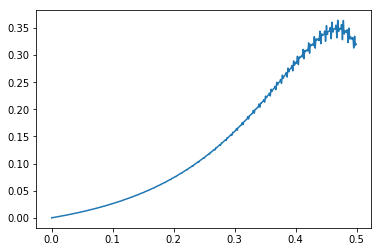

In [5]:
plt.plot(s[:surface_indx],dfds_real[:surface_indx])

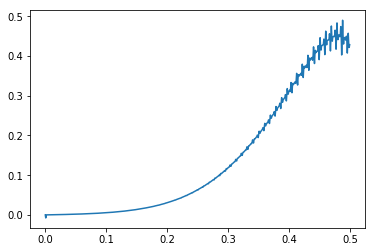

In [8]:
plt.plot(s[:surface_indx],dfds_real[:surface_indx])

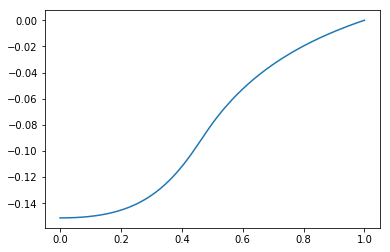

In [11]:
plt.plot(s,phi_new)

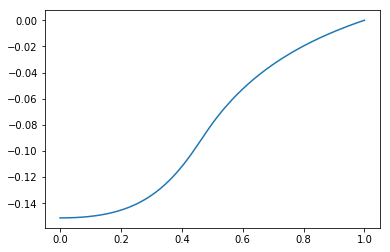

In [12]:
plt.plot(s,phi_new)

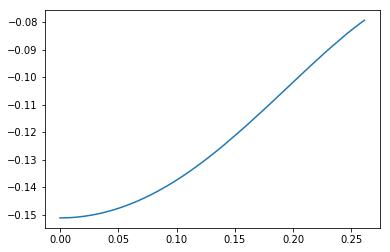

In [15]:
plt.plot(r[:surface_indx],phi_new[:surface_indx])